In [355]:
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower')
import numpy as np
from onset_detection import detected_samples
import matplotlib.pyplot as plt
import helper
import scipy.io.wavfile as wav
from datetime import datetime
import least_squares

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece



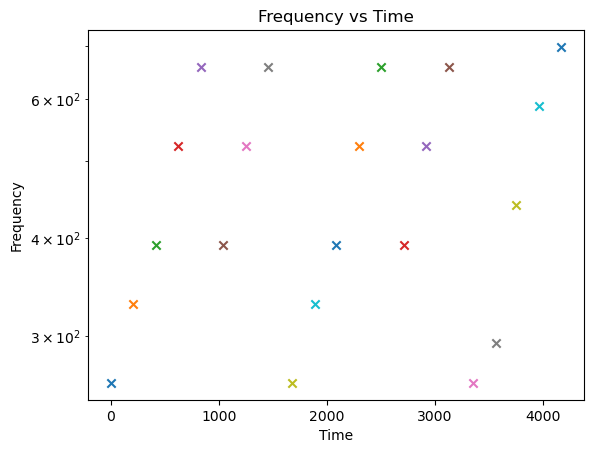

541


In [356]:
notes = process_midi_to_note_info(
    '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Prelude1.midi')
chords = notes_to_chords(notes, sustain=False)

plot_piece(chords, 20)
plt.show()
score = dict_to_frequency_list(chords)
print(len(score))


In [357]:
hop = 5000
sample_len = 1000
cov_dict = {}


/var/folders/n4/k97yk30s1wn32d7y6729kph80000gn/T/ipykernel_829/1272595947.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(path)


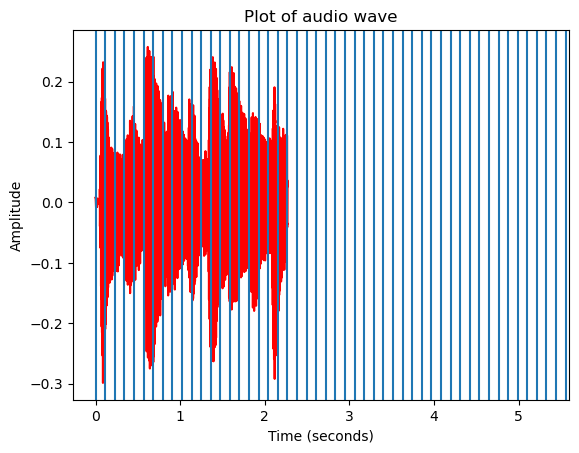

In [358]:
path =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_1.wav'
sample_rate, data = wav.read(path)

audio_duration = len(data)/sample_rate


time_samples = np.linspace(0, audio_duration, len(data))
sample_indices = np.arange(0, len(data), hop)
sample_data = [data[index:index+sample_len] for index in sample_indices]
helper.plot_audio(time_samples[:100000], data[:100000])
for i in sample_indices[:50]:
    plt.axvline(i/sample_rate)

In [384]:
def oltw(sample_data: list, score: list, time_samples: np.ndarray, n: int, pedal: bool = False, cov_dict:dict=None,back_track: int=0):
    state_number, audio_frame_number = 0, 0
    path = []
    for sample in sample_data[:-n]:
        ml = 0
        if np.sum(abs(sample))>10:
            lml = []
            num_lookahead = min(len(score) - state_number + 1, n) + back_track
            for i in range(num_lookahead):
                lml.append(-helper.stable_nlml(time_samples=time_samples, Y=sample, T=0.465, v=2.37, M=13,sigma_f=5, cov_dict=cov_dict, normalised=False,f=score[max(state_number+i-back_track, 0)]))
            
            # priors = 1/np.arange(1, num_lookahead+1)
            priors = [0.98,0.99,1,0.99,0.98,0.97]#np.ones(num_lookahead)
            lml =np.array(lml)
            normalised_lml = lml/np.sum(abs(lml)) # Normalise to 1 so that we can feasibly compute the ml (e^lml)
            posterior_ml = np.exp(normalised_lml) * priors

            index = np.argmax(posterior_ml)
            ml = posterior_ml

            state_number += index - back_track
        
        else:
            print("skipped the audio")
            
        audio_frame_number += 1
        path.append((state_number, audio_frame_number, ml))
    return path


In [360]:
sample_time_samples = np.linspace(0, sample_len/sample_rate, len(sample_data[0]))

for state in score[:250]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            sample_time_samples, sample_time_samples, M=9,  f=state, sigma_f=5, T=0.465, v=2.37) + 0.01**2 * np.eye(sample_len)

# path = oltw(sample_data[:30], score, sample_time_samples, 3)

In [361]:
len(cov_dict)

24

In [362]:
print(np.sum(np.abs(sample_data[0])))

4.193002943498868


In [385]:
path = oltw(sample_data[:30], score, sample_time_samples, n=4, cov_dict=cov_dict, back_track=2)

skipped the audio


In [364]:
print(path)

[(0, 1, 0), (0, 2, array([1.0197673 , 1.02957239, 0.82777005, 0.65687115, 0.67526059])), (0, 3, array([1.11419811, 1.12799693, 0.84283032, 0.68870392, 0.75718318])), (-1, 4, array([1.17619932, 1.11537066, 0.88046715, 0.69387633, 0.75094519])), (-1, 5, array([1.17039003, 1.30998886, 0.92650073, 1.0569753 , 0.63689592])), (-1, 6, array([1.28416207, 1.39472091, 1.13412216, 1.26228976, 0.95259179])), (-1, 7, array([1.01984871, 1.03832938, 0.48926057, 0.79861596, 0.99276727])), (-1, 8, array([1.11706641, 1.15780397, 0.57483591, 0.90630817, 1.08379189])), (-1, 9, array([1.04964429, 1.07288308, 1.01289342, 0.64905215, 0.62706367])), (-1, 10, array([1.0948245 , 1.12569722, 1.09192093, 0.70320701, 0.68282127])), (-1, 11, array([1.08274433, 1.11550541, 0.75960132, 0.90411304, 0.61502459])), (-1, 12, array([1.3427851 , 1.43409743, 1.08624642, 1.06659459, 1.13514091])), (-1, 13, array([1.01627778, 1.03350341, 0.47164434, 0.81472783, 0.9843351 ])), (-1, 14, array([1.07541248, 1.10500379, 0.55255644

/var/folders/n4/k97yk30s1wn32d7y6729kph80000gn/T/ipykernel_829/2936056108.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(link)


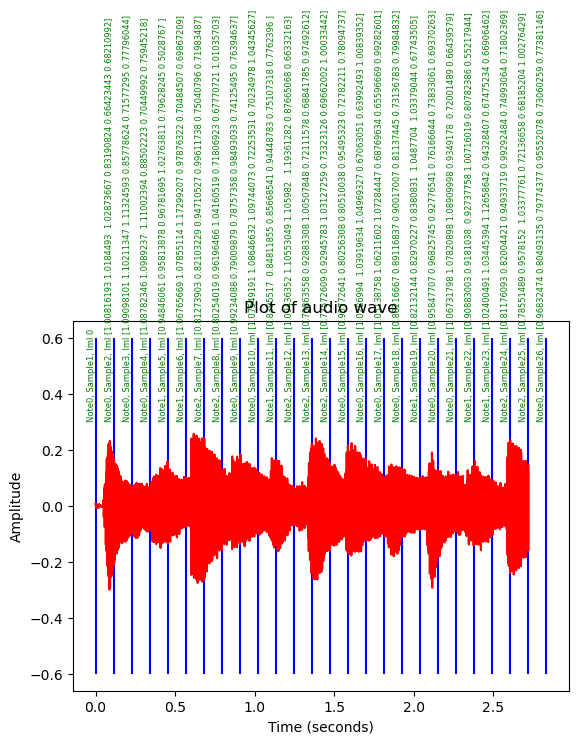

In [387]:
link =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_1.wav'
sample_rate, data = wav.read(link)
data=data[:120000]
audio_duration = len(data)/sample_rate
time_samples = np.linspace(0, audio_duration, len(data))
helper.plot_audio(time_samples, data)

for i in range(len(sample_indices[:26])):
    plt.vlines(sample_indices[i]/sample_rate, ymin=-
                       0.6, ymax=0.6, colors='blue', zorder=2)
    note = path[i][0]
    sample = path[i][1]
    lml = path[i][2]
    plt.text(sample_indices[i]/sample_rate, 0.3, f'Note{note}, Sample{sample}, lml {lml}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    

In [351]:
print(-helper.stable_nlml(sample_time_samples, sample_data[6], normalised=False,f=score[1],M=9, sigma_f=5, T=0.465, v=2.37))
print(-helper.stable_nlml(sample_time_samples, sample_data[6], normalised=False,f=score[2], M=9, sigma_f=5, T=0.465, v=2.37))

-17835.028056827658
2021.6505285851208


In [232]:
a = (-helper.stable_nlml(sample_time_samples, sample_data[7],normalised=False, f=score[2]))
b = (-helper.stable_nlml(sample_time_samples, sample_data[7],normalised=False, f=score[5]))
print(score[2],score[5])
probs = [a,b]
print(probs)
index = np.argmax(probs)
print(index)
print(probs[0])

[392] [392]
[-292437133059.6073, -292437133059.6073]
0
-292437133059.6073


In [109]:
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523]))
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523*2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523/2]))

3259.4427636762825
3252.2297267161425
3263.6486692849944


In [113]:
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[262]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[262*2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[262/2]))

3263.629826851649
3252.8785963126425
3285.4032855953687


In [112]:
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[523]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[523*2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[523/2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[523/4]))

3252.885091032817
3251.659525636543
3263.6507569273112
3285.5472934197237


15.286218989498593


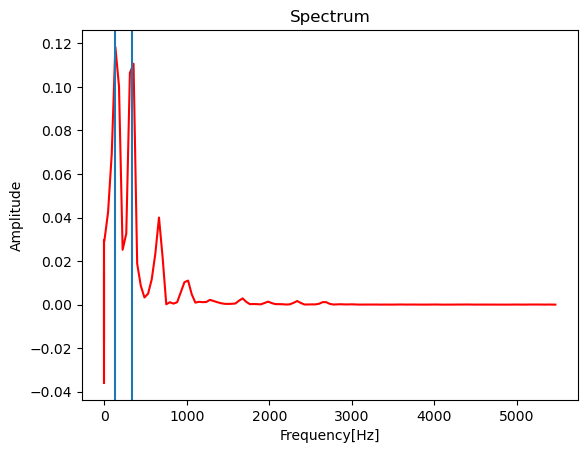

In [100]:
helper.plot_audio(sample_time_samples, sample_data[2])
helper.plot_fft(sample_data[2])
plt.axvline(261/2)
plt.axvline(330)
print(np.sum(abs(sample_data[3])))

In [91]:
print((-helper.relative_nlml(sample_time_samples, sample_data[2],M=15,sigma_f=5,  f=[261], T=0.465, v=2.37 )))
print((-helper.relative_nlml(sample_time_samples, sample_data[2],M=15, sigma_f=5, f=[330], T=0.465, v=2.37 )))

1it [00:00,  7.12it/s]
1it [00:00,  9.50it/s]

-3.658139087882506
-2.4897286877838316
